In [7]:
## data is taken from https://baseballsavant.mlb.com/statcast_search?hfPT=&hfAB=&hfGT=R%7C&hfPR=&hfZ=&hfStadium=&hfBBL=&hfNewZones=&hfPull=&hfC=&hfSea=2025%7C&hfSit=&player_type=pitcher&hfOuts=&hfOpponent=&pitcher_throws=&batter_stands=&hfSA=&game_date_gt=&game_date_lt=&hfMo=&hfTeam=134%7C&home_road=&hfRO=&position=&hfInfield=&hfOutfield=&hfInn=&hfBBT=&hfFlag=&metric_1=&group_by=name&min_pitches=0&min_results=0&min_pas=0&sort_col=pitches&player_event_sort=api_p_release_speed&sort_order=desc#results

In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import precision_recall_curve, average_precision_score, classification_report, roc_auc_score
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
pd.set_option('display.max_columns', None) 

#  Load data (downloaded from Baseball Savant for Pirates pitchers)
# data = pd.read_csv('/Users/romankoshovnyk/savant_data_pirates.csv')  
# Download dataset from GitHub 
csv_url = 'https://raw.githubusercontent.com/Shargat1996/pirates_sandbox/refs/heads/main/savant_data_pirates.csv'
# Load dataset
data = pd.read_csv(csv_url)
data.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,fielder_2,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,bat_speed,swing_length,estimated_slg_using_speedangle,delta_pitcher_run_exp,hyper_speed,home_score_diff,bat_score_diff,home_win_exp,bat_win_exp,age_pit_legacy,age_bat_legacy,age_pit,age_bat,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,pitcher_days_since_prev_game,batter_days_since_prev_game,pitcher_days_until_next_game,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle,attack_angle,attack_direction,swing_path_tilt,intercept_ball_minus_batter_pos_x_inches,intercept_ball_minus_batter_pos_y_inches
0,FF,2025-06-09,94.9,-0.82,6.29,"Burrows, Mike",660821,681347,sac_fly,hit_into_play,NaN,NaN,NaN,NaN,5,Jesús Sánchez out on a sacrifice fly to left f...,R,L,R,PIT,MIA,X,7.0,fly_ball,1,0,2025,-0.46,1.38,-0.02,2.81,681715.0,NaN,669364.0,0,5,Top,53.51,120.77,NaN,NaN,NaN,NaN,3.135994,-137.982572,-6.498342,-6.557993,33.021365,-13.277058,3.40,1.57,275.0,85.2,46.0,95.1,2283,6.6,777574,664954,687462,693304,663647,669707,624428,665833,668804,53.90,0.014,0.021,0.0,1.0,0.0,0.0,3.0,38,2,4-Seam Fastball,4,1,1,4,2,4,2,4,Standard,Standard,205,0.042,-0.264,70.4,6.4,0.032,0.264,88.0,3,-3,0.714,0.286,25,27,26,28,3,2,NaN,NaN,NaN,NaN,1.17,0.46,-0.46,NaN,-2.724609,9.413360,26.884283,36.421627,27.690714
1,FF,2025-06-09,94.4,-0.81,6.31,"Burrows, Mike",660821,681347,NaN,ball,NaN,NaN,NaN,NaN,11,Jesús Sánchez out on a sacrifice fly to left f...,R,L,R,PIT,MIA,B,NaN,NaN,0,0,2025,-0.49,1.45,-1.00,3.44,681715.0,NaN,669364.0,0,5,Top,NaN,NaN,NaN,NaN,NaN,NaN,0.595508,-137.303220,-4.952049,-6.300183,34.017916,-12.968651,3.40,1.57,NaN,NaN,NaN,94.2,2266,6.5,777574,664954,687462,693304,663647,669707,624428,665833,668804,54.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38,1,4-Seam Fastball,4,1,1,4,1,4,1,4,Standard,Standard,206,0.000,0.021,NaN,NaN,NaN,-0.021,NaN,3,-3,0.714,0.286,25,27,26,28,3,2,NaN,NaN,NaN,NaN,1.13,0.49,-0.49,NaN,NaN,NaN,NaN,NaN,NaN
2,FF,2025-06-09,94.3,-1.03,6.16,"Burrows, Mike",669364,681347,field_error,hit_into_play,NaN,NaN,NaN,NaN,6,Xavier Edwards reaches on a fielding error by ...,R,L,R,PIT,MIA,X,4.0,ground_ball,1,1,2025,-0.40,1.40,0.55,2.51,NaN,681715.0,NaN,0,5,Top,158.91,159.79,NaN,NaN,NaN,NaN,4.999153,-137.032533,-6.868551,-6.167512,33.122730,-13.214650,3.33,1.50,40.0,96.8,-1.0,94.3,2312,6.6,777574,664954,687462,693304,663647,669707,624428,665833,668804,53.91,0.369,0.355,0.9,1.0,0.0,0.0,2.0,37,3,4-Seam Fastball,4,1,1,4,1,4,1,4,Standard,Standard,207,-0.074,0.458,66.3,5.8,0.409,-0.458,96.8,3,-3,0.788,0.212,25,25,26,26,3,2,NaN,NaN,NaN,NaN,1.19,0.40,-0.40,NaN,0.774703,-1.819191,36.132249,25.694900,28.128908
3,FF,2025-06-09,95.0,-0.65,6.29,"Burrows, Mike",669364,681347,NaN,called_strike,NaN,NaN,NaN,NaN,8,Xavier Edwards reaches on a fielding error by ...,R,L,R,PIT,MIA,S,NaN,NaN,1,0,2025,-0.52,1.48,0.13,1.55,NaN,681715.0,NaN,0,5,Top,NaN,NaN,NaN,NaN,NaN,NaN,3.230261,-137.979993,-10.055122,-7.371367,31.121721,-11.273816,3.33,1.50,NaN,NaN,NaN,95.2,2341,6.5,777574,664954,687462,693304,663647,669707,624428,665833,668804,53.95,

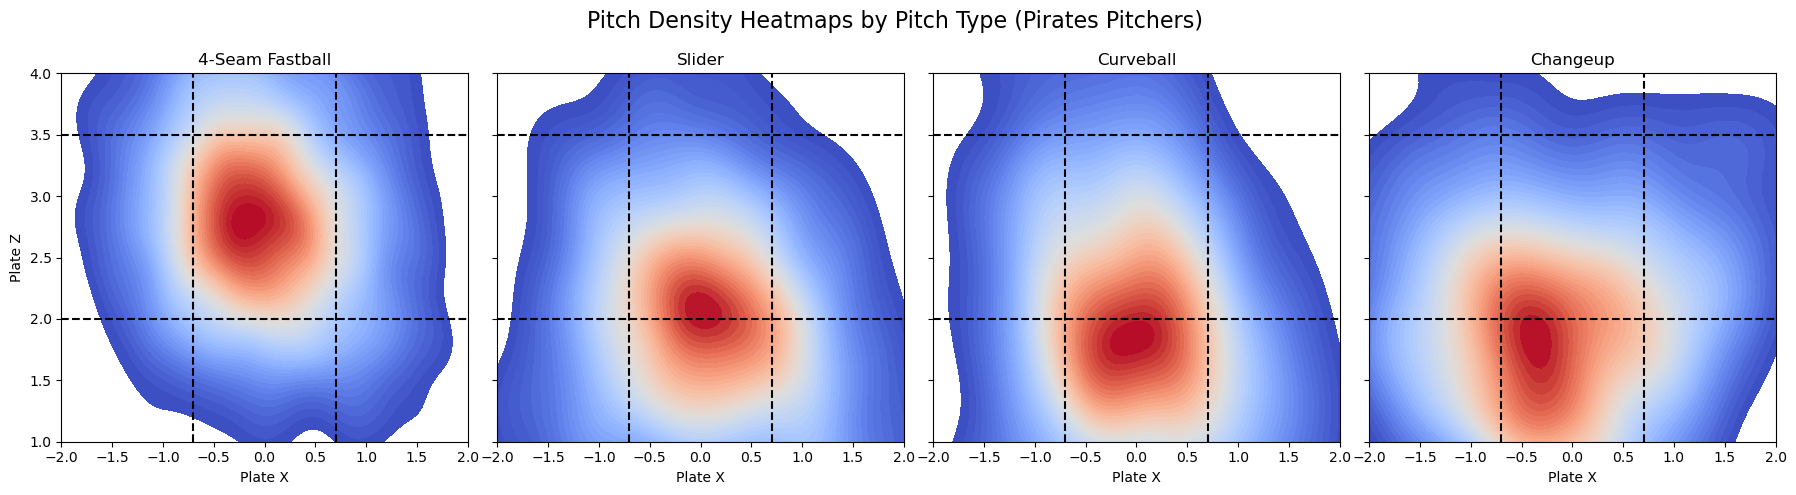

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns


pirates_data = data
pitch_types_to_plot = ['4-Seam Fastball', 'Slider', 'Curveball', 'Changeup']

fig, axes = plt.subplots(1, len(pitch_types_to_plot), figsize=(18, 5), sharey=True)

for ax, pitch in zip(axes, pitch_types_to_plot):
    subset = pirates_data[pirates_data['pitch_name'] == pitch]
    sns.kdeplot(
        data=subset,
        x='plate_x',
        y='plate_z',
        fill=True,
        cmap="coolwarm",
        ax=ax,
        levels=50,
        thresh=0.05
    )
    # Draw strike zone
    ax.set_xlim(-2, 2)
    ax.set_ylim(1, 4)
    ax.axhline(3.5, color='black', linestyle='--')
    ax.axhline(2.0, color='black', linestyle='--')
    ax.axvline(-0.7, color='black', linestyle='--')
    ax.axvline(0.7, color='black', linestyle='--')

    ax.set_title(pitch)
    ax.set_xlabel('Plate X')
    ax.set_ylabel('Plate Z')

fig.suptitle("Pitch Density Heatmaps by Pitch Type (Pirates Pitchers)", fontsize=16)
plt.tight_layout()
plt.show()


/var/folders/s3/fhd2___139j3q9bqq_cl4q740000gn/T/ipykernel_14676/3581095485.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap_data = (called_strikes
/opt/anaconda3/envs/catboost-env/lib/python3.9/site-packages/pandas/core/util/hashing.py:330: RuntimeWarning: invalid value encountered in cast
  vals.astype(str).astype(object), hash_key, encoding


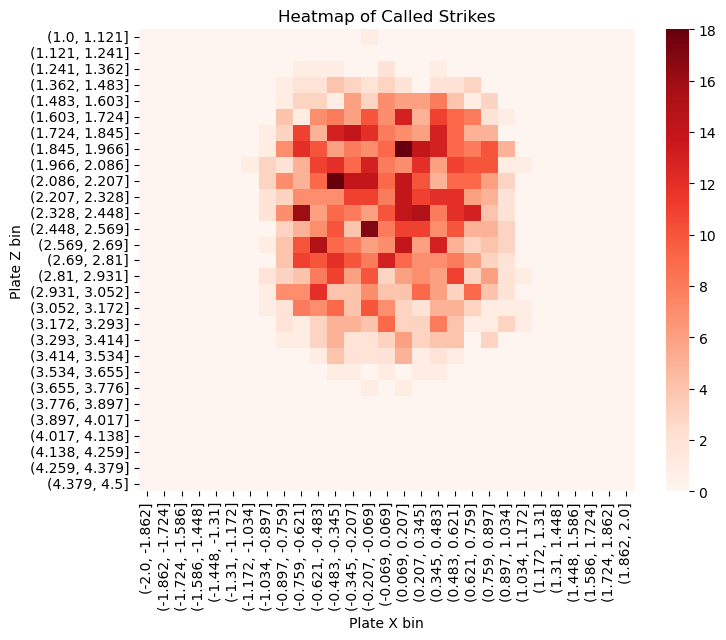

In [32]:
pirates_data['plate_x_bin'] = pd.cut(pirates_data['plate_x'], bins=np.linspace(-2, 2, 30))
pirates_data['plate_z_bin'] = pd.cut(pirates_data['plate_z'], bins=np.linspace(1, 4.5, 30))

# Choose called strikes
called_strikes = pirates_data[pirates_data['description'].isin(['called_strike'])]

heatmap_data = (called_strikes
                .groupby(['plate_x_bin', 'plate_z_bin'])
                .size()
                .unstack()
                .fillna(0))

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data.T, cmap='Reds', cbar=True)
plt.title("Heatmap of Called Strikes")
plt.xlabel("Plate X bin")
plt.ylabel("Plate Z bin")
plt.show()


Optimization terminated successfully.
         Current function value: 0.579211
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:        is_strike_pitch   No. Observations:                 9587
Model:                          Logit   Df Residuals:                     9581
Method:                           MLE   Df Model:                            5
Date:                Thu, 12 Jun 2025   Pseudo R-squ.:                 0.02618
Time:                        13:10:16   Log-Likelihood:                -5552.9
converged:                       True   LL-Null:                       -5702.2
Covariance Type:            nonrobust   LLR p-value:                 2.073e-62
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -1.3626      0.059    -23

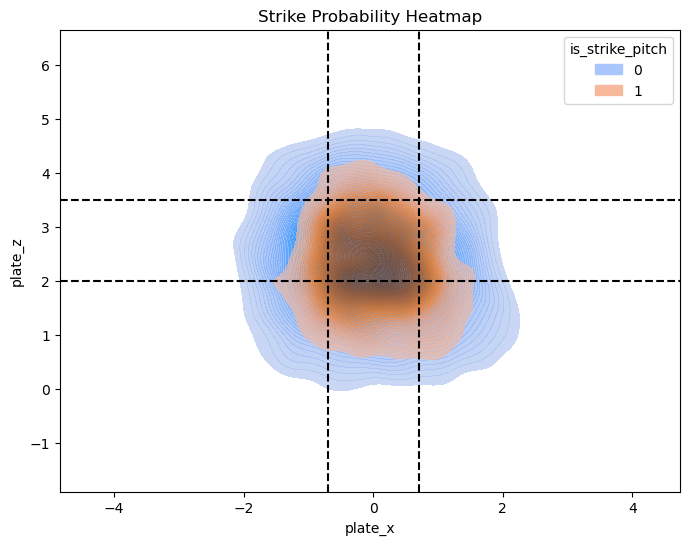

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

# === DATA PREP ===
df = data.copy()

# Target variable: was the pitch called a strike or resulted in a swinging strike
df['is_strike_pitch'] = df['description'].isin(['called_strike', 'swinging_strike', 'foul_tip', 'swinging_strike_blocked']).astype(int)

# Strike zone definition (adjust as needed)
x_min, x_max = -0.7, 0.7
z_min, z_max = 2.0, 3.5
df['in_strike_zone'] = ((df['plate_x'] >= x_min) & (df['plate_x'] <= x_max) &
                        (df['plate_z'] >= z_min) & (df['plate_z'] <= z_max)).astype(int)

# Encode p_throws as binary
df = df[df['p_throws'].isin(['R', 'L'])]
df['p_throws_encoded'] = df['p_throws'].map({'R':1, 'L':0}).astype(int)

# Encode pitch_type
df = df[df['pitch_type'].notnull()]
df['pitch_type_encoded'] = pd.factorize(df['pitch_type'])[0]

# Drop missing coordinate rows
df = df.dropna(subset=['plate_x', 'plate_z'])

# Features for factor model
features = ['in_strike_zone', 'p_throws_encoded', 'pitch_type_encoded',
            'in_strike_zone:p_throws_encoded', 'in_strike_zone:pitch_type_encoded']

# Formula for statsmodels
formula = 'is_strike_pitch ~ in_strike_zone + p_throws_encoded + pitch_type_encoded + in_strike_zone:p_throws_encoded + in_strike_zone:pitch_type_encoded'

# === FACTOR MODEL ===
model = smf.logit(formula=formula, data=df).fit()
print(model.summary())

# === AVERAGE MARGINAL EFFECTS (AME) ===
mfx = model.get_margeff()
print(mfx.summary())

# === STRIKE ZONE HEATMAP ===
plt.figure(figsize=(8,6))
hb = sns.kdeplot(
    data=df, x='plate_x', y='plate_z', hue='is_strike_pitch', fill=True, common_norm=False,
    palette='coolwarm', levels=50, alpha=0.7
)
plt.axvline(x=x_min, color='black', linestyle='--')
plt.axvline(x=x_max, color='black', linestyle='--')
plt.axhline(y=z_min, color='black', linestyle='--')
plt.axhline(y=z_max, color='black', linestyle='--')
plt.title('Strike Probability Heatmap')
plt.xlabel('plate_x')
plt.ylabel('plate_z')
plt.show()


In [34]:
pirates_data['description']

0       hit_into_play
1                ball
2       hit_into_play
3       called_strike
4                ball
            ...      
9582             ball
9583             ball
9584             foul
9585    called_strike
9586             ball
Name: description, Length: 9587, dtype: object

In [35]:
import pandas as pd
import numpy as np

# Define the strike pitch labels
strike_labels = ['called_strike', 'swinging_strike', 'foul_tip', 'swinging_strike_blocked']

# 0. Create binary target variable
pirates_data['is_strike_pitch'] = pirates_data['description'].isin(strike_labels).astype(int)
pirates_data = pirates_data.drop(columns=['description'])


# 1. Compute missing fractions
missing_frac = pirates_data.isna().mean()

# Drop columns with >30% missing
cols_to_drop = missing_frac[missing_frac > 0.3].index.tolist()
data_clean = pirates_data.drop(columns=cols_to_drop).copy()

print(f"Dropped {len(cols_to_drop)} columns with >30% missing.")

# 2. Handle low-missing columns (≤5%) first
missing_frac = data_clean.isna().mean()
cols_low_missing = missing_frac[missing_frac <= 0.05].index.tolist()
cols_high_missing = missing_frac[(missing_frac > 0.05) & (missing_frac <= 0.3)].index.tolist()

numeric_cols = data_clean[cols_low_missing].select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = data_clean[cols_low_missing].select_dtypes(include=['object', 'category']).columns.tolist()

# Median impute numeric low-missing columns
for col in numeric_cols:
    if data_clean[col].isna().any():
        data_clean[col] = data_clean[col].fillna(data_clean[col].median())

# Mode impute categorical low-missing columns
for col in categorical_cols:
    if data_clean[col].isna().any():
        mode_val = data_clean[col].mode()[0]
        data_clean[col] = data_clean[col].fillna(mode_val)

# 3. Handle high-missing columns (5-30%)
for col in cols_high_missing:
    if data_clean[col].dtype in [np.float64, np.int64]:  # Numeric
        data_clean[f'{col}_missing'] = data_clean[col].isna().astype(int)
        data_clean[col] = data_clean[col].fillna(0)
    else:  # Categorical
        data_clean[f'{col}_missing'] = data_clean[col].isna().astype(int)
        data_clean[col] = data_clean[col].astype('category')

# 4. One-hot encode categorical variables (both low-missing and high-missing)
categorical_cols_all = data_clean.select_dtypes(include=['object', 'category']).columns.tolist()
data_clean = pd.get_dummies(data_clean, columns=categorical_cols_all, drop_first=True, dtype=int)

# 5. Create 'in_strike_zone' dummy based on plate_x and plate_z
x_min, x_max = -0.7, 0.7
z_min, z_max = 2.0, 3.5
data_clean['in_strike_zone'] = (
    (data_clean['plate_x'] >= x_min) & (data_clean['plate_x'] <= x_max) &
    (data_clean['plate_z'] >= z_min) & (data_clean['plate_z'] <= z_max)
).astype(int)

# 6. One-hot encode pitch_name separately
pitch_dummies = pd.get_dummies(pirates_data['pitch_name'], prefix='pitch', drop_first=True, dtype=int)

# 7. Create interaction terms between pitch dummies and in_strike_zone
interaction_terms = pitch_dummies.multiply(data_clean['in_strike_zone'], axis=0)
interaction_terms.columns = [f"{col}_x_in_strike_zone" for col in interaction_terms.columns]

# 8. Concatenate all together
data_clean = pd.concat([data_clean, pitch_dummies, interaction_terms], axis=1)

# 9. Final cleanup: ensure numeric
data_clean = data_clean.apply(pd.to_numeric, errors='coerce')

# 10. Add constant for intercept
data_clean['const'] = 1

print(f"Final cleaned data shape: {data_clean.shape}")


Dropped 35 columns with >30% missing.
Final cleaned data shape: (9587, 2412)


In [36]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import re

def clean_col_name(name):
    name = name.replace(' ', '_').replace('.', '').replace(',', '')
    return re.sub(r'[^A-Za-z0-9_]+', '', name)

# Create a dict mapping old names to cleaned names
new_columns = {col: clean_col_name(col) for col in data_clean.columns}

# Rename columns in place
data_clean.rename(columns=new_columns, inplace=True)

def build_ols(data, target,  pval_thresh=0.05):
    """Builds OLS model with splines for significant numeric predictors."""
    numeric_predictors = [col for col in data.columns 
                          if col != target and data[col].dtype in [np.float64, np.int64]]
    
    # Quick OLS to find significant numeric predictors
    X_full = sm.add_constant(data[numeric_predictors])
    initial_model = sm.OLS(data[target], X_full).fit()
    significant_numeric = [var for var in numeric_predictors 
                           if var in initial_model.pvalues and initial_model.pvalues[var] < pval_thresh]
    
    print(f"Significant numeric predictors (p<{pval_thresh}): {significant_numeric}")
    return significant_numeric


In [37]:
significant_numeric = build_ols(data_clean, target='is_strike_pitch')


Significant numeric predictors (p<0.05): ['release_speed', 'balls', 'strikes', 'vy0', 'sz_top', 'sz_bot', 'effective_speed', 'release_pos_y', 'pitch_number', 'away_score', 'bat_score', 'fld_score', 'post_away_score', 'post_bat_score', 'post_fld_score', 'delta_run_exp', 'delta_pitcher_run_exp', 'bat_score_diff', 'api_break_x_arm', 'pitcher_days_until_next_game_missing', 'pitch_type_FC', 'pitch_type_FS', 'game_date_20250408', 'player_name_Santana_Dennis', 'des_Agustn_Ramrez_grounds_out_shortstop_Jared_Triolo_to_first_baseman_Spencer_Horwitz', 'des_Andy_Pages_doubles_3_on_a_line_drive_to_right_fielder_Bryan_Reynolds', 'des_Austin_Wells_grounds_out_sharply_second_baseman_Jared_Triolo_to_first_baseman_Endy_Rodrguez', 'des_Blake_Dunn_called_out_on_strikes', 'des_Brandon_Nimmo_flies_out_to_left_fielder_Alexander_Canario', 'des_Brayan_Rocchio_walks', 'des_Brendan_Donovan_called_out_on_strikes', 'des_Bryson_Stott_strikes_out_swinging', 'des_Caleb_Durbin_doubles_6_on_a_fly_ball_to_left_fielder_T

In [38]:
# Features of interest: pitch dummies + their interaction terms
pitch_features = [
    'pitch_Changeup', 'pitch_Curveball', 'pitch_Cutter', 'pitch_Sinker', 'pitch_Slider',
    'pitch_Slow Curve', 'pitch_Slurve', 'pitch_Split-Finger', 'pitch_Sweeper'
]
interaction_features = [f"{feat}_x_in_strike_zone" for feat in pitch_features]
selected_features = [f for f in pitch_features + interaction_features if f in data_clean.columns]

In [39]:
selected_features

['pitch_Changeup',
 'pitch_Curveball',
 'pitch_Cutter',
 'pitch_Sinker',
 'pitch_Slider',
 'pitch_Slurve',
 'pitch_Sweeper',
 'pitch_Changeup_x_in_strike_zone',
 'pitch_Curveball_x_in_strike_zone',
 'pitch_Cutter_x_in_strike_zone',
 'pitch_Sinker_x_in_strike_zone',
 'pitch_Slider_x_in_strike_zone',
 'pitch_Slurve_x_in_strike_zone',
 'pitch_Sweeper_x_in_strike_zone']

[0]	validation_0-logloss:0.57071


/var/folders/s3/fhd2___139j3q9bqq_cl4q740000gn/T/ipykernel_14676/1002696099.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  X[col] = X[col].apply(extract_scalar)
/opt/anaconda3/envs/catboost-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [13:10:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	validation_0-logloss:0.20978
[100]	validation_0-logloss:0.18958
[150]	validation_0-logloss:0.18762
[199]	validation_0-logloss:0.18672
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.91      0.94      6884
           1       0.81      0.96      0.88      2703

    accuracy                           0.92      9587
   macro avg       0.89      0.93      0.91      9587
weighted avg       0.93      0.92      0.92      9587

ROC AUC: 0.9816
Brier Score: 0.0528


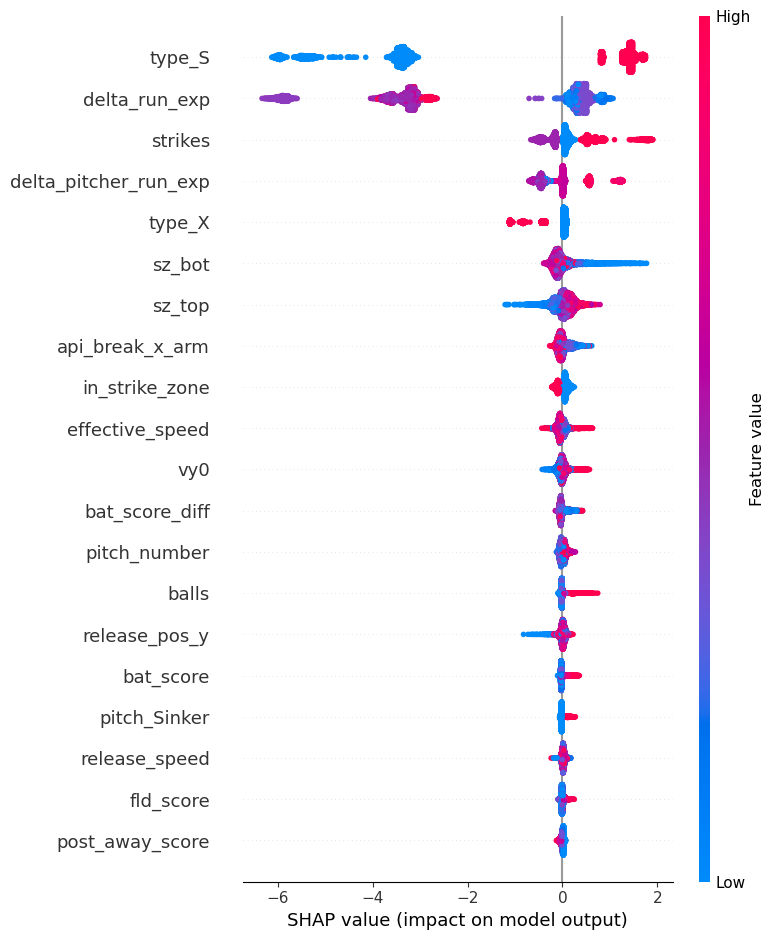

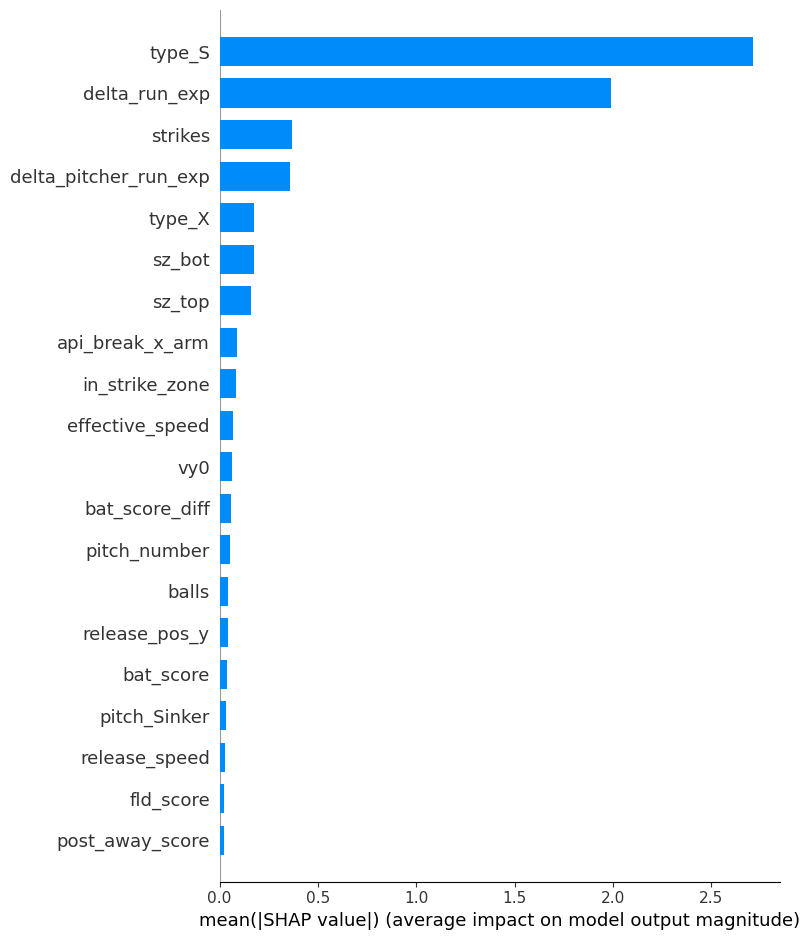

In [40]:
import numpy as np
import pandas as pd
import xgboost as xgb
import shap
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import brier_score_loss


# Prepare data
# Extract features and label
X = data_clean[significant_numeric + selected_features].copy()
y = data_clean['is_strike_pitch']

# Clean problematic columns by extracting scalar if needed and coercing to numeric
def extract_scalar(val):
    if isinstance(val, pd.Series):
        return val.iloc[0]
    return val

for col in X.columns:
    X[col] = X[col].apply(extract_scalar)

# Coerce all columns to numeric, replace errors with NaN
X = X.apply(pd.to_numeric, errors='coerce')

# Fill NaNs with 0 (or consider other imputation if better)
X.fillna(0, inplace=True)

# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Convert train and val sets to numpy float32 arrays for XGBoost
X_train_np = X_train.astype(np.float32).values
X_val_np = X_val.astype(np.float32).values
y_train_np = y_train.values
y_val_np = y_val.values

# Initialize XGBoost classifier
xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    n_estimators=200,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=15217,
    n_jobs=-1,
    verbosity=2
)

# Fit model with evaluation monitoring
xgb_clf.fit(
    X_train_np, y_train_np,
    eval_set=[(X_val_np, y_val_np)],
    verbose=50
)

# Predict on full dataset
X_np = X.astype(np.float32).values
y_pred_prob = xgb_clf.predict_proba(X_np)[:, 1]
y_pred = xgb_clf.predict(X_np)

# Print classification report and ROC AUC
print("Classification Report:\n", classification_report(y, y_pred))
print(f"ROC AUC: {roc_auc_score(y, y_pred_prob):.4f}")
brier_score = brier_score_loss(y, y_pred_prob)
print(f"Brier Score: {brier_score:.4f}")
# SHAP explanation
explainer = shap.TreeExplainer(xgb_clf)

try:
    # Pass numpy array for shap_values to avoid dtype issues
    shap_values = explainer.shap_values(X_np)
except AttributeError:
    # Fallback if shap_values is deprecated
    shap_values = explainer(X_np).values

# Use DataFrame for nicer plot labels
X_for_plot = pd.DataFrame(X_np, columns=X.columns)

# SHAP summary plots
shap.summary_plot(shap_values, X_for_plot, plot_type="dot")
shap.summary_plot(shap_values, X_for_plot, plot_type="bar")
